## Mini model
How quickly does model leanr? Implication of task difficulty in CIFAKE?

train on dev data
train on 1 batch of train data

In [8]:
## Imports
import random
import json
import torch

from classes import  CI_LOADER, CIFAKE_CNN
from test import test_model, score_preds, test_thresh_size, visualise
from train import get_files, train_model
import matplotlib.pyplot as plt


with open('./config.json') as f:
    config = json.load(f)

src_dir = config['CIFAKE_dir']  # https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/data, Dec 11, 14:05

In [4]:
# load data
data = get_files(src_dir)
# Split data
trainfiles = data['train'][:int(len(data['train']))]
testfiles = data['test']

trainfiles[0]  # tuple of filepath + class as str
len(trainfiles), trainfiles[0]

(100000, ('../data/CIFAKE/train/REAL/1006 (3).jpg', 'REAL'))

In [5]:
traindata = CI_LOADER(trainfiles, batch_size=32)
testdata = CI_LOADER(testfiles, batch_size=32)

In [6]:
mini_traindata = CI_LOADER(trainfiles[:3456], batch_size=32)

In [10]:
tiny_model = CIFAKE_CNN()
tiny_model = train_model(tiny_model, mini_traindata, epochs=1, learn_rate=0.001)

  0%|          | 0/108 [00:00<?, ?it/s]

epoch: 0	total loss: 74.95879185199738	avg loss: 0.6940628875184942
Finished Training


eval

In [ ]:
# instead: every x batches, compute acc on dev set & plot
# train loss v valid acc

  0%|          | 0/625 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

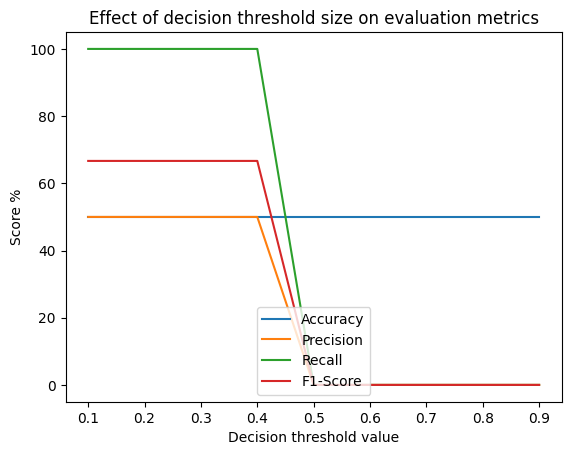

In [11]:
# testing
tiny_gold, tiny_preds = test_model(tiny_model, testdata)
tiny_df = test_thresh_size(tiny_gold, tiny_preds)
visualise(tiny_df)

In [12]:
tiny_df

,Accuracy,Precision,Recall,F1-Score
0.1,50.0,50.0,100.0,66.666667
0.2,50.0,50.0,100.0,66.666667
0.3,50.0,50.0,100.0,66.666667
0.4,50.0,50.0,100.0,66.666667
0.5,50.0,0.0,0.0,0.000000
0.6,50.0,0.0,0.0,0.000000
0.7,50.0,0.0,0.0,0.000000
0.8,50.0,0.0,0.0,0.000000
0.9,50.0,0.0,0.0,0.000000


In [13]:
tiny_df.describe()

,Accuracy,Precision,Recall,F1-Score
count,9.0,9.000000,9.000000,9.000000
mean,50.0,22.222222,44.444444,29.629630
std,0.0,26.352314,52.704628,35.136418
min,50.0,0.000000,0.000000,0.000000
25%,50.0,0.000000,0.000000,0.000000
50%,50.0,0.000000,0.000000,0.000000
75%,50.0,50.000000,100.000000,66.666667
max,50.0,50.000000,100.000000,66.666667


In [14]:
# find peak for each metric
for x in zip([a for a in tiny_df.max().items()], tiny_df.idxmax()):
    print(x)

(('Accuracy', 50.0), 0.1)
(('Precision', 50.0), 0.1)
(('Recall', 100.0), 0.1)
(('F1-Score', 66.66666666666666), 0.1)


## Explore difficulty of task

In [15]:
len(traindata.batches)  #mini was 108

3125

In [16]:
inc_traindata = CI_LOADER(trainfiles[:int(len(trainfiles)*0.95)])
inc_devdata = CI_LOADER(trainfiles[int(len(trainfiles)*0.95):])

In [18]:
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
import torch.nn as nn

criterion = nn.BCELoss()  # match loss for binary classification

def acc_fcn(model, thresh=0.5):
    gold, preds = list(), list()
    # n_batches = len(devdata)//devdata.batch_size
    tloss=0
    with torch.no_grad():
        for batch in inc_devdata:
            X, y_true = batch
            # calculate outputs by running images through the network
            output = model(X)
            tloss += criterion(output, y_true.reshape(-1, 1)).item()  # reshape for single dim

            # Store true and predicted class labels
            gold.extend(list(np.array(y_true)))
            preds.extend(list(np.array(output.squeeze())))
    y_pred = [1 if pred >= thresh else 0 for pred in preds]
    acc = accuracy_score(gold, y_pred)

    return acc, tloss/len(inc_devdata.batches)


def log_train(model: CIFAKE_CNN, data: list[tuple], epochs: int = 5,
          learn_rate: float = 0.001, momentum: float = 0.9) -> CIFAKE_CNN:
    """Train and return CNN for binary image classification.

    Args:
        model (CIFAKE_CNN): CNN model structure
        data (list[tuple]): List of (filename, class label) items as str
        epochs (int, optional): Number of epochs. Defaults to 5.
        learn_rate (float, optional): Optimizer learn rate. Defaults to 0.001.
        momentum (float, optional): Momentum for optimizer. Defaults to 0.9.

    Returns:
        CIFAKE_CNN: CNN model for binary image classification
    """
    # own function, structure base from cifar10_tutorial.ipynb, but modified
    # everthing but the running_loss usage
    criterion = nn.BCELoss()  # match loss for binary classification
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)
    n_batches=len(data)//data.batch_size  # determine nr of batches for pretty tqdm

    logs = dict()#{'accs': list(), 'losses': list()}
    for epoch in range(epochs):
        total_loss = 0 #change to dict, start logging, 
        running_loss = 0
        tloss=0
        for i, batch in tqdm(enumerate(data), total=n_batches):
            # reset gradient
            optimizer.zero_grad()

            # Extract input and labels, make predictions
            X, y = batch
            output = model(X)


            # calculate & store loss
            loss = criterion(output, y.reshape(-1, 1))  # reshape for single dim
            running_loss += loss.item()
            total_loss += loss.item()
            tloss += loss.item()
            # backpropagate & update gradient
            loss.backward()
            optimizer.step()


            if i>0 and not i%5:
                logs[i] = dict()
                acc, l =  acc_fcn(model)
                logs[i]['accs']  = acc
                logs[i]['v_losses'] = l
                logs[i]['t_losses'] = total_loss/(i+1)
                #tloss/5+1
                tloss = 0
                #total_loss/(i+1)

            # print statistics
            if i % (n_batches//4) == (n_batches//4)-1:
                print(f'[{epoch+1}, {i+1:5d}] avg loss: {running_loss/(n_batches//4):.3f}',
                      end='\r')  # kept from class notebook, udpated with n_batches
                running_loss = 0.0



        print(f'\repoch: {epoch}\ttotal loss: {total_loss}\tavg loss: {total_loss/n_batches}')
        break
    print('Finished Training')

    return model, logs


In [24]:
mini_model = CIFAKE_CNN()
mini_model, accs = log_train(mini_model, inc_traindata, epochs=1)

  0%|          | 0/2968 [00:00<?, ?it/s]

epoch: 0	total loss: 1890.8453207015991	avg loss: 0.6370772643873313
Finished Training


In [19]:
torch.save(mini_model.state_dict(), config['mini_model'])

eval

In [ ]:
mini_model = CIFAKE_CNN()
mini_model.load_state_dict(torch.load(config['mini_model']))

<All keys matched successfully>

In [25]:
# predict labels
gold, preds = test_model(mini_model, testdata)
# evaluate with accuracy, precision, recall, f1-score
eval = score_preds(gold, preds, verbose=True)

  0%|          | 0/625 [00:00<?, ?it/s]


Performance (n=20000 test imgs, decision threshold=0.5)
Overall accuracy: 76.41%

              score
precision  0.769192
recall     0.754500
f1-score   0.761775


In [26]:
import pandas as pd
a = pd.DataFrame(accs)
a

,5,10,15,20,25,30,35,40,45,50,...,2920,2925,2930,2935,2940,2945,2950,2955,2960,2965
accs,0.497796,0.497796,0.497796,0.497796,0.497796,0.497796,0.497796,0.497796,0.497796,0.497796,...,0.763822,0.759215,0.763822,0.765825,0.767228,0.762220,0.765024,0.758213,0.758413,0.770633
v_losses,0.693874,0.693850,0.693829,0.693803,0.693772,0.693742,0.693722,0.693700,0.693689,0.693670,...,0.492202,0.492230,0.487723,0.487423,0.486605,0.490022,0.488370,0.491218,0.491210,0.481878
t_losses,0.693769,0.693667,0.693602,0.693526,0.693885,0.693528,0.693373,0.693291,0.693114,0.693162,...,0.639361,0.639129,0.639000,0.638796,0.638528,0.638224,0.638045,0.637772,0.637501,0.637212


<Axes: >

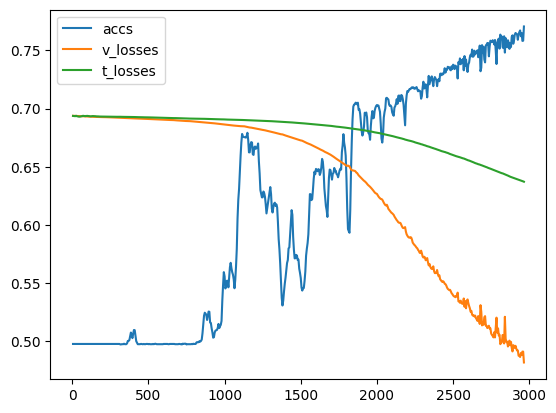

In [27]:
a.transpose().plot()


<Axes: >

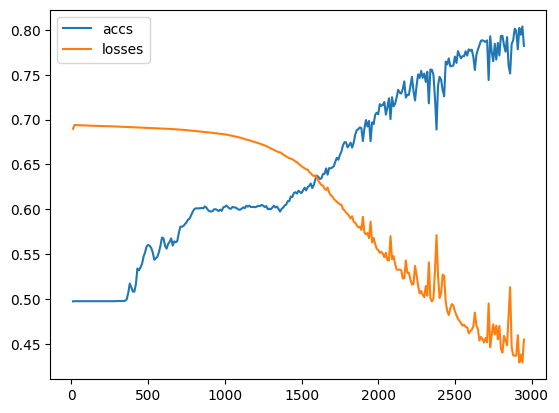

In [80]:
a.transpose().plot()
# acc, val loss, 10er

<Axes: >

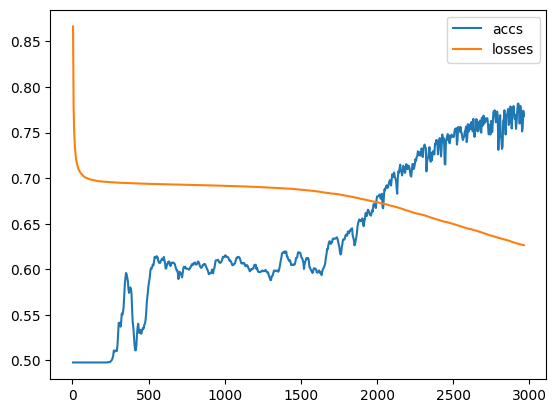

In [64]:
a.transpose().plot()
# acc, t loss avg; 4er

<Axes: >

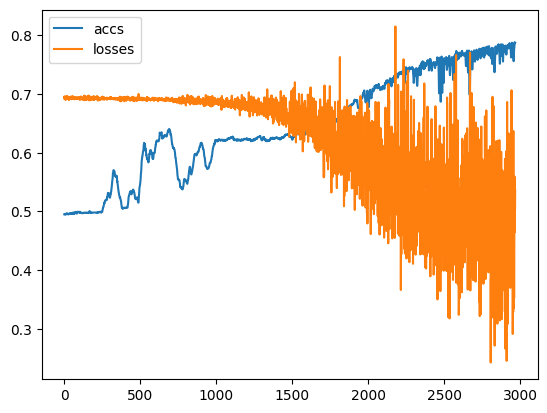

In [57]:
a.transpose().plot()
# every batch

<Axes: >

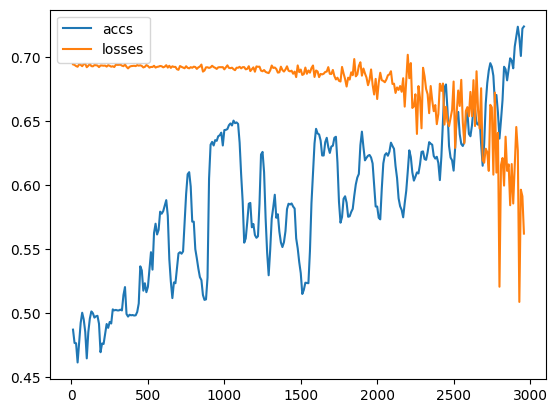

In [ ]:
a.transpose().plot()
# every 10 batches